In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json

## Get exact weather data

In [2]:
def open_csv(file, folder, separator):
    """ Open a csv file in a inputs subfolder given a file name, a folder and a separator. """
    if folder != 'inputs':
        path = os.path.join(os.pardir, 'inputs', folder, file)
    else:
        path = os.path.join(os.pardir, 'inputs', file)
    return pd.read_csv(path , sep = separator, engine='python')

def to_date_time(df, column):
    """ Convert a dataframe column to datetime and set it as index. """
    df[[column]] = pd.DataFrame(pd.to_datetime(df[column], format='%d.%m.%Y %H:%M'))
    df.set_index(column, inplace = True)

def time_delta(delta):
    """ Get a timedelta object from a given string with a fomat hrs_min_sec as "00:00:00" hours 
        minutes seconds.
    """
    t = datetime.strptime(delta,"%H:%M:%S")
    return timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)

def weather_data_to_df(file, period_start, period_end, timestep):
    """ Create a dataframe from a csv file of meteorological data for a given period and with a 
        given timestep
    """
    folder = 'external'
    df = open_csv(file, folder, ';')
    to_date_time(df, 'Date')
    
    df = df.truncate(before = period_start, after = period_end)
    
    # Sum over Irradiance values: units of Irradiance are now kWh/m^2/h = kW/m^2
    df = df.resample(time_delta(timestep)).agg({'Irradiance': np.sum, 'Temperature': np.mean})
    df['Irradiance'] /= 1000 
    return df

def reshape_day_hour(hourly_indexed_list, Days, Hours):
    """ Reshape a list with hourly index to a list of list with daily and hour 
    in day index """
    return (np.reshape(hourly_indexed_list, (len(Days), len(Hours))))

# Weather parameters for a summer day at Liebensberg
file = 'meteo_Liebensberg_10min.csv'
start, stop, time_Step, Date_format = '2019-01-01', '2020-01-01', '01:00:00', '%Y-%m-%d'
df_weather = weather_data_to_df(file, start, stop, time_Step)
df_weather.drop(df_weather.tail(1).index,inplace=True)

dt_start = datetime.strptime(start, Date_format)
dt_end = datetime.strptime(stop, '%Y-%m-%d')

# Day index
Days = list(range((dt_end - dt_start).days))

# Hour index
Hours = list(range(0,24))

# External temperature - format Ext_T[Day_index,Hour_index]
epsilon = 1e-6
Ext_T = reshape_day_hour((df_weather['Temperature'].values), Days, Hours)
Ext_T[np.abs(Ext_T) < epsilon] = 0

# Global irradiance
Irradiance = reshape_day_hour((df_weather['Irradiance'].values), Days, Hours)
Irradiance[np.abs(Irradiance) < epsilon] = 0

## Get cluster results

In [3]:
def calc_error(closest, measured, Hours):
    error = np.zeros(len(Hours))
    for h in Hours:
        if closest[h] - measured[h] == 0:
            error[h] = 0
        elif closest[h] == 0:
            error[h] = 1
        else:
            error[h] = (closest[h] - measured[h])/closest[h]
    return error

def MSE(closest, measured, Hours):
    MSE = (closest - measured)**2/len(Hours)
    return MSE

def read_json(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data['labels'], data['closest']

def scale(a):
    scaled_a = np.zeros(np.shape(a))
    for i,_ in enumerate(scaled_a):
        Min, Max = np.min(a), np.max(a)
        scaled_a[i] = (a[i] - Min)/(Max - Min)
    return scaled_a

In [4]:
def get_error(start_cluster, stop_cluster, iterations, identifier, Days, Hours, Ext_T, Irradiance):
    
    nbr_of_clusters = [str(i) for i in range(start_cluster, stop_cluster + 1)]
    Error_by_cluster_nbr, Best_iteration = [], []
            
    for k in nbr_of_clusters:
        Error = {}
        E = np.zeros(iterations)
        for n in range(iterations):
            path = os.path.join('jsons', f'clusters_{identifier}_{n}.json')
            labels, closest = read_json(path)
            Error[n] = np.zeros((len(Days), len(Hours)*2))
            for d in Days:
                closest_day = closest[k][labels[k][d]]       

                Error[n][d, :24] = MSE(Ext_T[closest_day], Ext_T[d], Hours)
                Error[n][d, 24:] = MSE(Irradiance[closest_day], Irradiance[d], Hours)

            E[n] = np.mean(Error[n]**2)

        Best_iteration.append(np.argwhere(E == min(E))[0,0])
        Error_by_cluster_nbr.append([min(E)*1e7, max(E)*1e7])
    return Error_by_cluster_nbr, Best_iteration

In [5]:
Error_by_cluster_nbr, Best_iteration = get_error(8, 12, 100, 6, Days, Hours, scale(Ext_T), scale(Irradiance))
Error_by_cluster_nbr, Best_iteration

([[5.410738101069878, 7.947325507211505],
  [5.004600195899195, 7.917068327747303],
  [4.492262561804495, 7.345516475840581],
  [4.395681567971908, 6.781188922608652],
  [4.202888739025736, 5.901826734088521]],
 [43, 41, 47, 44, 13])

In [6]:
Error_by_cluster_nbr, Best_iteration = get_error(8, 12, 100, 6, Days, Hours, Ext_T, Irradiance)
Error_by_cluster_nbr, Best_iteration

([[1375841.9282960354, 1799558.7538870627],
  [1262322.600843811, 1683008.3960529107],
  [1137912.6981205095, 1466616.4141727777],
  [982508.5483008104, 1553216.4093154776],
  [892224.9667679374, 1700265.3565499214]],
 [3, 2, 85, 3, 42])

In [7]:
Error_by_cluster_nbr, Best_iteration = get_error(2, 19, 30, 5, Days, Hours, scale(Ext_T), scale(Irradiance))
Error_by_cluster_nbr, Best_iteration

([[19.76897971840846, 19.76897971840846],
  [16.833516908907782, 17.342184661535477],
  [10.699396812580924, 14.016992668056625],
  [7.266956678932541, 10.879289524007728],
  [6.44611244412197, 8.813183949951252],
  [5.689857469622526, 7.780777896236108],
  [5.401651535047976, 7.815424033332865],
  [5.451801171818117, 7.3455650497367335],
  [4.518588130304192, 6.12271089832317],
  [4.5854407357784694, 5.877981034202475],
  [4.385789973611404, 5.930224968611724],
  [4.298242257276348, 5.899728316394596],
  [4.123110305480994, 5.909071791671058],
  [3.50086431945494, 5.264954848720683],
  [3.4041907972533885, 4.799481274456025],
  [3.143555991782227, 4.81987911877265],
  [3.2401180412383015, 4.560611525856654],
  [3.0833610783224294, 4.411650486420864]],
 [0, 0, 14, 18, 2, 18, 5, 16, 28, 9, 27, 9, 1, 26, 27, 14, 1, 12])

In [8]:
Error_by_cluster_nbr, Best_iteration = get_error(2, 19, 30, 5, Days, Hours, Ext_T, Irradiance)
Error_by_cluster_nbr, Best_iteration

([[11818130.661125774, 11818130.661125774],
  [5008707.823455929, 5111787.272538092],
  [3540729.1073585073, 4505899.751283285],
  [2858948.1857896596, 3475831.168656808],
  [1830247.3759005805, 2495705.4845387894],
  [1594973.8228323893, 2493901.7934150565],
  [1385638.1788080886, 1822386.9413368965],
  [1273191.7203083546, 1588148.9470929336],
  [1189079.0696931207, 1495976.7199226157],
  [1045576.2192295637, 1508806.7109073084],
  [934648.5351260983, 1572039.8705275813],
  [877054.8660688174, 1545411.4672616061],
  [861140.2654462132, 1204012.771924254],
  [765781.4675923435, 1172113.6398045698],
  [745200.9575866305, 1057046.1599692826],
  [667665.9017075144, 999011.0235016395],
  [595383.3483871026, 955642.0397782571],
  [617470.4355546242, 903986.4592331841]],
 [0, 1, 4, 28, 5, 4, 24, 20, 24, 5, 23, 10, 18, 7, 0, 24, 11, 8])

In [9]:
def plot_clustered_data(identifier, iteration, nbr_of_clusters, Hours, Days, Ext_T, Irradiance):
    path = os.path.join('jsons', f'clusters_{identifier}_{iteration}.json')
    labels, closest = read_json(path)
    #print('labels ', labels[nbr_of_clusters], 'closest', closest[nbr_of_clusters])
    set_of_labels = {}
    for i in labels.keys():
        set_of_labels[i] = set(labels[i])

    # clustered_days[Cluster][Days][0: Ext_t, 1: Irradiance][Hours]
    clustered_days = {}
    for d in Days:
        typical_period = labels[nbr_of_clusters][d]
        try:
            a = clustered_days[typical_period]
        except:
            clustered_days[typical_period] = []
        clustered_days[typical_period].append([Ext_T[d], Irradiance[d]])

    for i in set_of_labels[nbr_of_clusters]:
        fig, ax1 = plt.subplots()
        plt.title('External parameter clusters')
        ax1.set_xlabel('Hours')
        ax1.set_ylabel('Temperature in °C')
        ax2 = ax1.twinx()
        ax2.set_ylabel('Global Irradiance in kW/m^2')
        for d in range(len(clustered_days[i])):

            ax1.plot(Hours, clustered_days[i][d][0], label=f'Typical day nbr {i}', c='blue')
            ax2.plot(Hours, clustered_days[i][d][1], label=f'Typical day nbr {i}', c='red')

            ax1.plot(Hours, Ext_T[closest[nbr_of_clusters][i]], label=f'Typical day nbr {i}', c='lightblue', linewidth=5)
            ax2.plot(Hours, Irradiance[closest[nbr_of_clusters][i]], label=f'Typical day nbr {i}', c='orange', linewidth=5)


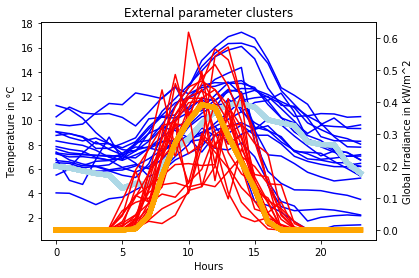

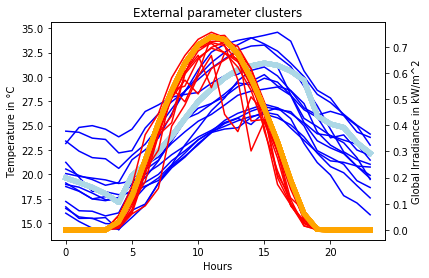

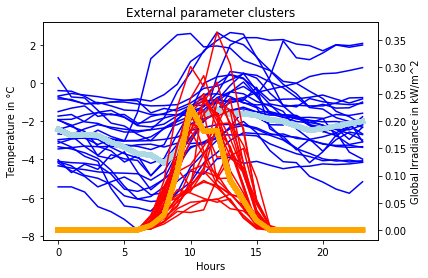

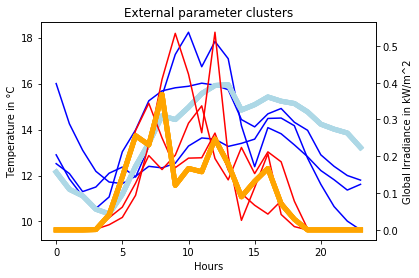

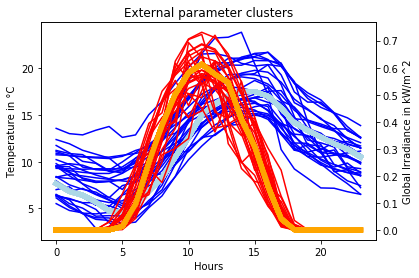

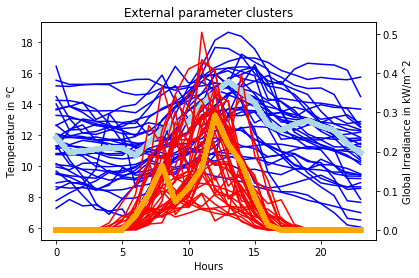

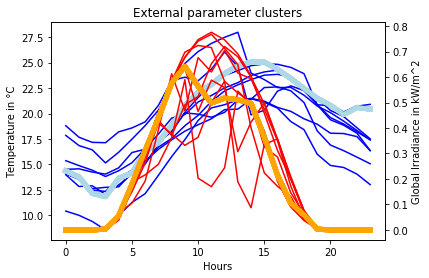

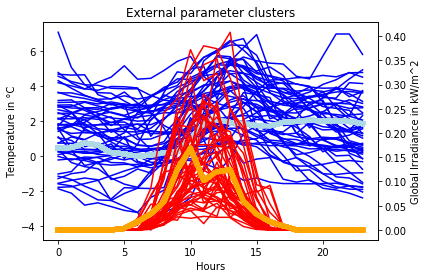

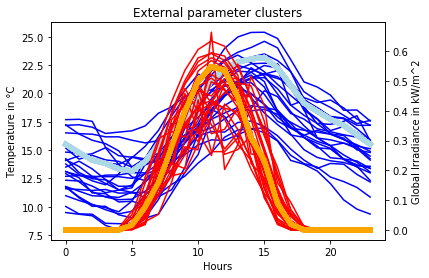

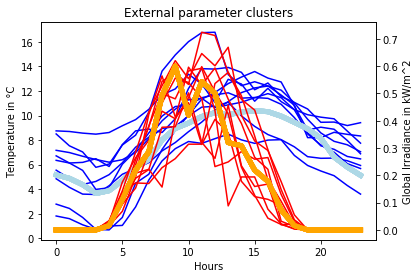

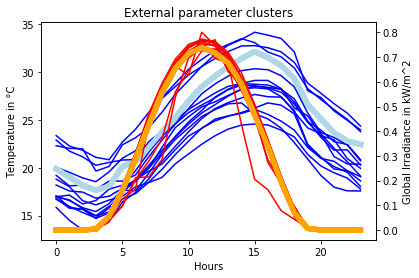

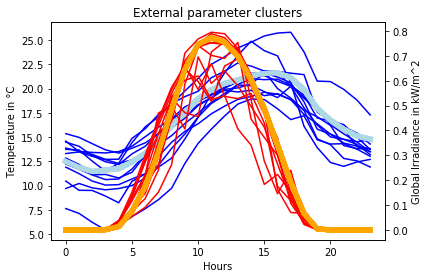

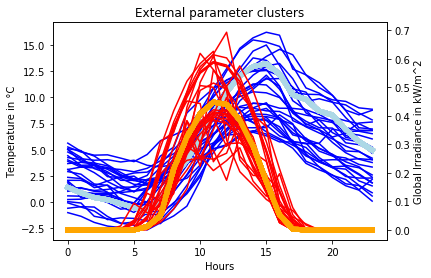

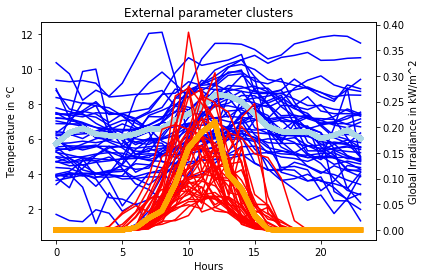

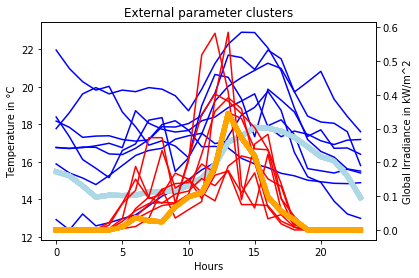

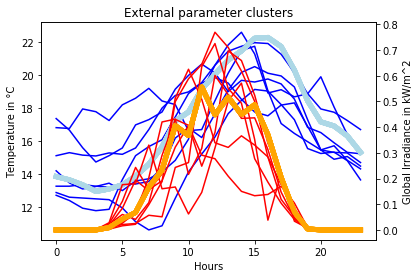

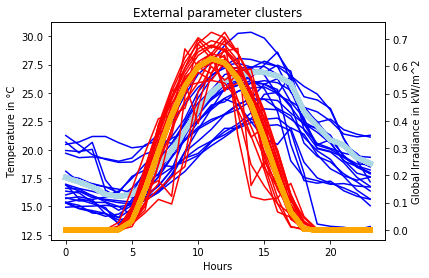

In [10]:
plot_clustered_data(5, 14, '17', Hours, Days, Ext_T, Irradiance)

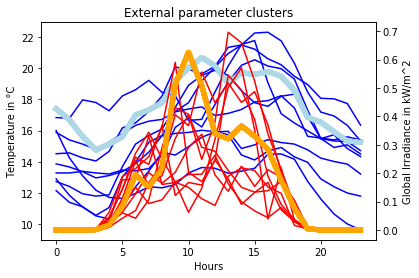

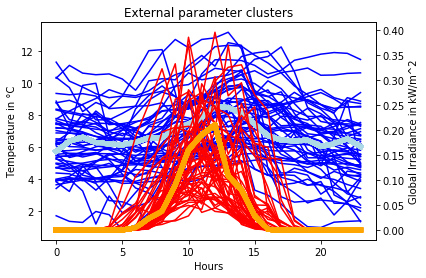

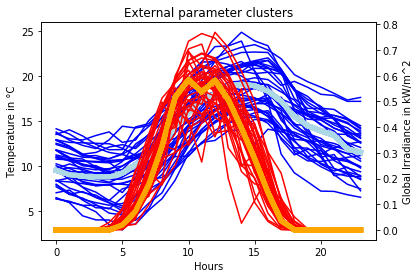

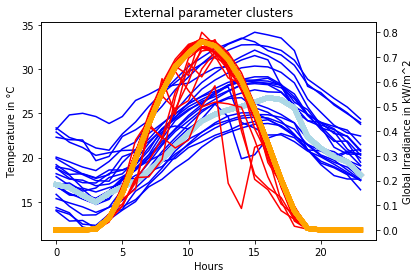

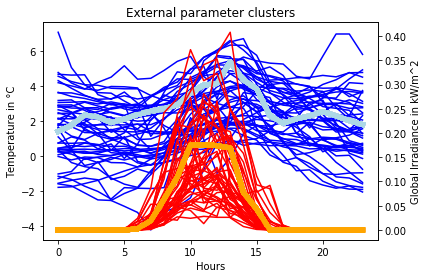

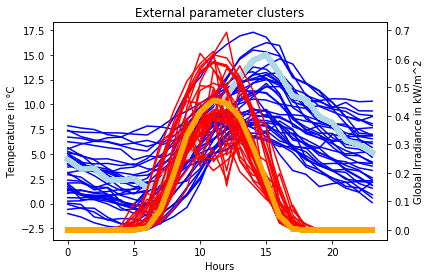

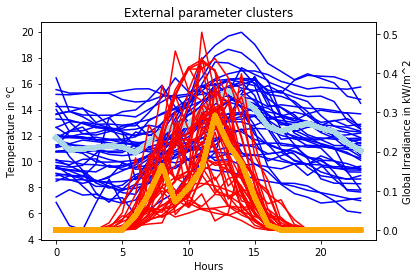

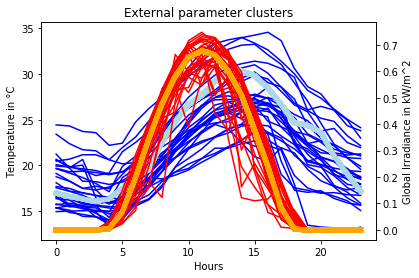

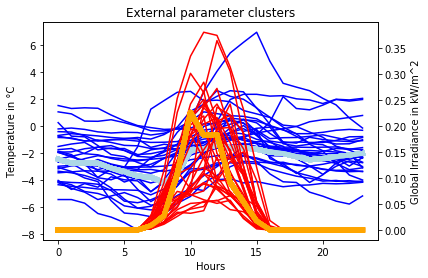

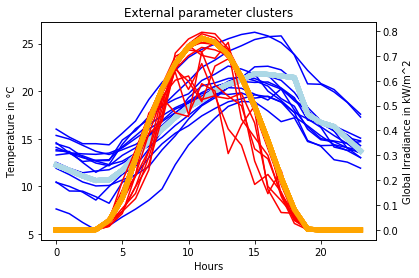

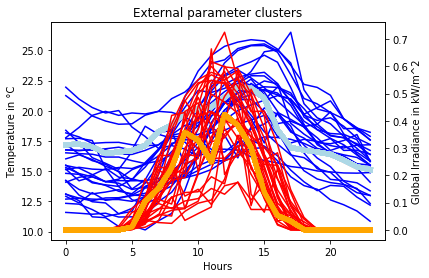

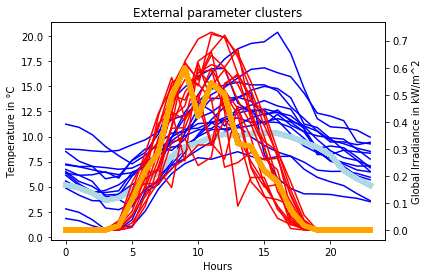

In [11]:
plot_clustered_data(6, 50, '12', Hours, Days, Ext_T, Irradiance)

#

In [410]:
nbr_of_clusters, iterations, identifier = '10', 50, 6
    
Error = {}
E = np.zeros(iterations)
path = os.path.join('jsons', f'clusters_{identifier}_{iteration}.json')
labels, closest = read_json(path)
Error[n] = np.zeros((len(Days), len(Hours)*2))
aprox_mean_temp = []
for d in closest[nbr_of_clusters]:       
    print(d, np.mean(Ext_T[d]))
    aprox_mean_temp.append(np.mean(Ext_T[d]))
    
measure_mean_temp = []
for d in Days:       
    measure_mean_temp.append(np.mean(Ext_T[d]))

309 6.771527777777777
146 16.238194444444442
290 12.416666666666666
90 10.646527777777779
184 20.961805555555554
10 -2.4819444444444443
103 1.2340277777777777
216 22.1875
50 6.1375
256 17.804166666666667


In [411]:
closest['10']

[309, 146, 290, 90, 184, 10, 103, 216, 50, 256]

In [20]:
Labels = [7, 7, 2, 2, 2, 7, 7, 7, 7, 2, 2, 7, 7, 7, 7, 7, 7, 2, 2, 2, 2, 2, 2, 
          2, 2, 7, 7, 7, 2, 2, 2, 7, 7, 7, 2, 2, 2, 2, 7, 13, 13, 7, 7, 7, 12, 
          12, 12, 12, 12, 0, 12, 12, 13, 12, 12, 12, 12, 12, 0, 13, 13, 0, 13, 
          12, 12, 0, 13, 13, 0, 7, 12, 7, 7, 13, 4, 0, 7, 12, 12, 12, 12, 4, 4, 
          0, 12, 12, 12, 4, 4, 4, 4, 4, 0, 7, 12, 12, 0, 0, 0, 13, 13, 12, 12, 
          7, 12, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 13, 0, 12, 0, 0, 4, 9, 0, 0, 12, 
          9, 9, 13, 9, 4, 0, 9, 9, 9, 9, 9, 4, 4, 4, 5, 5, 4, 11, 6, 3, 11, 11, 
          5, 9, 11, 11, 6, 10, 6, 10, 1, 3, 11, 11, 3, 5, 3, 15, 6, 6, 16, 15, 
          6, 10, 10, 15, 6, 14, 6, 10, 10, 10, 10, 10, 10, 10, 1, 10, 10, 10, 
          10, 6, 16, 15, 11, 11, 15, 15, 11, 11, 15, 11, 1, 1, 1, 1, 1, 1, 1, 
          1, 1, 1, 16, 14, 16, 1, 15, 16, 14, 16, 16, 16, 14, 14, 16, 1, 14, 
          16, 14, 8, 11, 8, 16, 8, 16, 8, 5, 8, 14, 8, 16, 16, 16, 16, 16, 16, 
          16, 16, 14, 5, 4, 8, 5, 5, 5, 5, 4, 4, 8, 8, 8, 8, 8, 16, 8, 8, 4, 4, 
          4, 8, 5, 5, 5, 5, 8, 8, 8, 8, 8, 5, 12, 13, 5, 5, 0, 5, 5, 5, 0, 8, 
          8, 8, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 13, 13, 13, 5, 5, 
          5, 13, 13, 13, 7, 7, 7, 7, 13, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 13, 13, 
          13, 13, 13, 13, 13, 7, 7, 7, 2, 2, 2, 7, 13, 13, 13, 7, 2, 7, 7, 13, 
          5, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 7, 13, 7, 2, 2, 2] 

In [414]:
Unique_labels = list(set(Labels))

In [415]:
def get_nearby(start, stop, Labels):
    if start >= 0 and stop <= len(Labels):
        return Labels[start:stop]
    else:
        if start <= 0:
            return Labels[len(Labels) + start:-1] + Labels[0:stop]
        else:
            return Labels[start:-1] + Labels[0:stop - len(Labels)]
        
def unique(l):
    return list(set([int(i) for i in l]))

In [469]:
count_near_day = {}
for d in Days:
    count_near_day[d] = {}
    Unique_labels = unique(Labels)
    l = len(Unique_labels)
    nearby = get_nearby(d - l, d + l, Labels)
    for p in unique(nearby):
        c = nearby.count(p)
        count_near_day[d][p] = c
        #print(f'Near day {d}, period {p} appears {c} times')

In [466]:
top_near_day = np.zeros(len(Days))
for d in Days:
    index = np.argmax(list(count_near_day[d].values()))
    top_near_day[d] = list(count_near_day[d].keys())[index]

In [421]:
distance = len(Unique_labels)
while len(unique(top_near_day)) != len(Unique_labels):
    count_near_day = {}
    for d in Days:
        count_near_day[d] = {}
        Unique_labels = unique(Labels)
        nearby = get_nearby(d - distance, d + distance, Labels)
        for p in unique(nearby):
            c = nearby.count(p)
            count_near_day[d][p] = c
            
    top_near_day = np.zeros(len(Days))
    for d in Days:
        index = np.argmax(list(count_near_day[d].values()))
        top_near_day[d] = list(count_near_day[d].keys())[index]
    print(distance, top_near_day)
    
    distance -= 1

17 [ 7.  7.  7.  7.  7.  7.  7.  2.  2.  2.  7.  7.  2.  2.  2.  2.  7.  7.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  7.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.
  9.  9. 11. 11. 11. 11. 11. 11. 11. 11. 11.  6.  6.  6.  6.  6.  6. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 16. 16.  8.  8.  8.  8.  8.  8.

10 [ 7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  7.  7.
  7.  7.  2.  7.  7.  7. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 13. 13. 13. 13. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 12. 12.  4.  4.  4.  4. 12. 12. 12. 12. 12.
  4.  4.  4. 12. 12. 12.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  0.  0.  0.  9.  9.
  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9. 11.
 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 16. 16. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 16.  8.  8.  8. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.

In [451]:
def reduce_reorder(order, period):
    period_occure = np.where(np.array(order) == period)[0]
    length = {}
    i = 0
    j = period_occure[0]
    for n, _ in enumerate(period_occure):
        try:
            if period_occure[n + 1] == period_occure[n] + 1:
                i += 1
            else:
                length[j] = i + 1
                i = 0
                j = period_occure[n+1]
        except:
            length[j] = i + 1
    print(length)
    key_max = max(length, key=length.get)
    for k in list(length.keys())[::-1]:
        l = length[k]
        if k == key_max:
            print('max', k, l)
            order[k:k+l] = [period]
        else:
            print('any', k, l)
            order[k:k+l] = []
    return order

In [471]:
distance = 4
count_near_day = {}
for d in Days:
    count_near_day[d] = {}
    Unique_labels = unique(Labels)
    nearby = get_nearby(d - distance, d + distance, Labels)
    for p in unique(nearby):
        c = nearby.count(p)
        count_near_day[d][p] = c

top_near_day = np.zeros(len(Days))
for d in Days:
    index = np.argmax(list(count_near_day[d].values()))
    top_near_day[d] = list(count_near_day[d].keys())[index]
print(distance, top_near_day)

top_near_day = np.zeros(len(Days))
for d in Days:
    index = np.argmax(list(count_near_day[d].values()))
    top_near_day[d] = list(count_near_day[d].keys())[index]

4 [ 2.  2.  2.  7.  7.  7.  2.  2.  7.  7.  7.  7.  7.  7.  7.  7.  7.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  7.  7.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  7.  7.  7. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 12.  0. 13. 13.  0. 13. 12.  0.  7. 13.  7.
  7.  7.  7.  7. 12. 12. 12. 12. 12. 12. 12. 12. 12.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  0.  0.  0.  0.  0.  0.  0. 12. 12. 12.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  0.  0.  0.  0.  0.  0.  0.  0.  9.  9.
  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  4.  4.  4.  4.  4. 11.
 11. 11. 11. 11. 11. 11. 11.  6.  6.  6.  6.  6.  3.  3.  3.  3.  3.  3.
  3.  3.  6.  6.  6.  6.  6.  6.  6. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 15. 11. 11. 11. 11. 11. 11.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 14. 14. 14.  8.  8.  8. 16.  8.  8.  8.  8.  8.  8. 16.
  8. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.  5. 

In [472]:
order = top_near_day

frequency = []
for i in unique(top_near_day):
    frequency.append(np.count_nonzero(top_near_day == i))
frequency = [unique(top_near_day), frequency]

order = list(top_near_day)
for i in unique(top_near_day):
    smallest = frequency[0].pop(np.argmin(frequency[1]))
    frequency[1].pop(np.argmin(frequency[1]))
    print('-----------',smallest)
    print('length order', len(order))
    print(order)
    order = reduce_reorder(list(order), smallest)
    print('*********remaining. ', np.count_nonzero(np.array(order) == smallest))
    

----------- 15
length order 365
[2.0, 2.0, 2.0, 7.0, 7.0, 7.0, 2.0, 2.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 7.0, 7.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 7.0, 7.0, 7.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 0.0, 13.0, 13.0, 0.0, 13.0, 12.0, 0.0, 7.0, 13.0, 7.0, 7.0, 7.0, 7.0, 7.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 12.0, 12.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 4.0, 4.0, 4.0, 4.0, 4.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 6.0, 6.0, 6.0, 6.0, 6.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10

In [473]:
order

[2, 12, 4, 0, 9, 11, 3, 6, 10, 15, 1, 16, 14, 8, 5, 7, 13]

In [474]:
Unique_labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [475]:
difference = list(set(Unique_labels) - set(order))
difference

[]

In [476]:
order

[2, 12, 4, 0, 9, 11, 3, 6, 10, 15, 1, 16, 14, 8, 5, 7, 13]

In [470]:
order

[2, 12, 4, 9, 11, 6, 10, 1, 16, 8, 5, 7, 13]